In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import os
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

## 1) Load the dataset

In [2]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
COMPANY = 'CBA.AX'
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-08-01'
while True:
    try:
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"

# Check if the data file exists
if os.path.exists(data_filename):
    # If it exists, load the data from the file
    print(f"Loading data from {data_filename}")
    data = pd.read_csv(data_filename, index_col=0, parse_dates=True, date_format='%Y-%m-%d')
else:
    # If it does not exist, save the data to the file
    print(f"Saving data to {data_filename}")
    data.to_csv(data_filename)
    print(f"Data saved to {data_filename}")

Using training period: 2020-01-01 to 2023-08-01
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Loading data from data/CBA.AX_data.csv


## 2) Clean and preprocess the data

In [3]:
df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Price', 'Close', 'High', 'Low', 'Volume']

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert the financial data columns to numeric
numeric_columns = ['Price', 'Close', 'High', 'Low', 'Volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())


Cleaned data saved to data/CBA.AX_cleaned_data.csv
Cleaned Data Sample:
        Date      Price      Close       High        Low   Volume
0 2020-01-02  64.933311  65.209696  64.534999  64.860155  1416232
1 2020-01-03  65.282852  65.998196  65.234081  65.819360  1622784
2 2020-01-06  64.843887  64.933305  64.404935  64.811377  2129260
3 2020-01-07  66.006325  66.006325  65.177184  65.697430  2417468
4 2020-01-08  65.762459  66.046968  65.055246  66.022582  1719114


In [4]:
df = pd.read_csv(cleaned_data_filename)

def split_by_ratio_sequential(df, test_size_ratio):
    """Splits the data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Splits the data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Splits the data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ")
    
    if choice == '1':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter the cutoff date (YYYY-MM-DD): ")
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = float(input("Enter the test size ratio (e.g., 0.2 for 20%): "))
        test_ratio = ratio if 0 < ratio < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")
        
# Print the shapes of the train and test datasets
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 30.0% for testing.
Train data shape: (708, 6)
Test data shape: (304, 6)


In [5]:
# Scale the feature columns and store scalers
from sklearn.preprocessing import MinMaxScaler
import pickle

# Define the feature columns to scale (excluding Date if it's a column)
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Dictionary to store scalers for each feature
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        # Create a separate scaler for each feature
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Fit the scaler on training data only
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        
        # Transform test data using the same scaler
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        
        # Store the scaler in the dictionary
        scalers[column] = scaler
        
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers to file for future use
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Display scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Function to load scalers from file
def load_scalers(filename):
    """Load scalers from pickle file"""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Scalers file {filename} not found!")
        return None

# Function to inverse transform scaled data
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale"""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        return scaler.inverse_transform(scaled_predictions.reshape(-1, 1)).flatten()
    else:
        print(f"Scaler for column '{column_name}' not found!")
        return scaled_predictions

# Example usage of loading scalers (for future sessions)
# loaded_scalers = load_scalers(scalers_filename)
# if loaded_scalers:
#     print("Scalers loaded successfully!")

# Display sample of scaled data
print("\nSample of scaled training data:")
print(scaled_train_data.head())

print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [48.0495, 96.5344]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [44.4250, 95.6616]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.5615, 96.2451]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [350619.0000, 17021972.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 4
Scaled features: ['Close', 'High', 'Low', 'Volume']
Train data shape after scaling: (708, 6)
Test data shape after scaling: (304, 6)

Sample of scaled training data:
         Date      Price     Close      High       Low    Volume
0  2020-01-02  64.933311  0.353929  0.392493  0.368305  0.063919
1  2020-01-03  65.282852  0.370192  0.406137  0.387611  0.076308
2  2020-01-06  64.843887  0.348228  0.389955  0.367323  0.106688
3  2020-01-07  66.006325  0.370359  0.405027  0.385157  0.123976
4  2020-01-08  65.762

In [6]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# 4) Build the model

In [7]:
#------------------------------------------------------------------------------
# Build the Model
## Enhanced with:
# 1) Check if data has been built before. If so, load the saved data
# 2) Check if model has been trained before. If so, load the saved model
# 3) Use multiple features for better accuracy
# 4) Model saving and loading functionality
#------------------------------------------------------------------------------

# Define file paths for saving/loading
MODEL_DIR = "models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model_filename = f"{MODEL_DIR}/{COMPANY}_lstm_model.h5"
training_data_filename = f"{DATA_DIR}/{COMPANY}_training_data.npz"

# Prepare the training data using multiple features
print("Preparing training sequences...")

# Select features for training (exclude Date column)
available_features = [col for col in ['Close', 'High', 'Low', 'Price', 'Volume'] if col in scaled_train_data.columns]
print(f"Available features: {available_features}")

# Check if training data has been built before
if os.path.exists(training_data_filename):
    print(f"Loading pre-built training data from {training_data_filename}")
    training_data = np.load(training_data_filename)
    X_train = training_data['X_train']
    y_train = training_data['y_train']
    X_test = training_data['X_test']
    y_test = training_data['y_test']
    num_features = training_data['num_features']
    print(f"Loaded training data - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
else:
    print("Building training sequences from scratch...")
    
    # Prepare feature data
    train_feature_data = scaled_train_data[available_features].values
    test_feature_data = scaled_test_data[available_features].values
    
    # Create sequences using the enhanced function
    X_train, y_train = create_dataset(train_feature_data, look_back=PREDICTION_DAYS)
    X_test, y_test = create_dataset(test_feature_data, look_back=PREDICTION_DAYS)
    
    num_features = len(available_features)
    
    print(f"Training sequences created:")
    print(f"  X_train shape: {X_train.shape}")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_test shape: {y_test.shape}")
    print(f"  Number of features: {num_features}")
    
    # Save the training data
    np.savez(training_data_filename,
             X_train=X_train, y_train=y_train,
             X_test=X_test, y_test=y_test,
             num_features=num_features)
    print(f"Training data saved to {training_data_filename}")

# Check if model has been trained before
if os.path.exists(model_filename):
    print(f"Loading pre-trained model from {model_filename}")
    model = tf.keras.models.load_model(model_filename)
    print("Model loaded successfully!")
    print(model.summary())
else:
    print("Building and training new model...")
    
    # Build the enhanced model
    model = Sequential()
    
    # First LSTM layer with multiple features input
    model.add(LSTM(units=50, return_sequences=True, input_shape=(PREDICTION_DAYS, num_features)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model with enhanced settings
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae', 'mse']  # Additional metrics for monitoring
    )
    
    print("Model architecture:")
    model.summary()
    
    # Train the model with enhanced parameters
    print("Training the model...")
    history = model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_data=(X_test, y_test),  # Monitor validation performance
        verbose=1,
        shuffle=False  # Important for time series data
    )
    
    # Save the trained model
    model.save(model_filename)
    print(f"Model saved to {model_filename}")
    
    # Save training history
    history_filename = f"{MODEL_DIR}/{COMPANY}_training_history.npz"
    np.savez(history_filename,
             loss=history.history['loss'],
             val_loss=history.history['val_loss'],
             mae=history.history['mae'],
             val_mae=history.history['val_mae'])
    print(f"Training history saved to {history_filename}")

# Function to load a pre-trained model
def load_pretrained_model(model_path):
    """Load a pre-trained model from file"""
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Function to save current model
def save_current_model(model, model_path):
    """Save the current model to file"""
    try:
        model.save(model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

# Display model performance summary
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Model file: {model_filename}")
print(f"Training data shape: {X_train.shape}")
print(f"Features used: {available_features}")
print(f"Prediction days: {PREDICTION_DAYS}")
print(f"Total parameters: {model.count_params():,}")

# Evaluate the model on test data
print("\nEvaluating model on test data...")
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test RMSE: {np.sqrt(test_mse):.6f}")

# Calculate accuracy percentage
test_predictions = model.predict(X_test)
# Convert back to original scale for meaningful accuracy calculation
original_predictions = inverse_transform_predictions(test_predictions, 'Close', scalers)
original_actual = inverse_transform_predictions(y_test.reshape(-1, 1), 'Close', scalers)

# Calculate percentage accuracy
percentage_errors = np.abs((original_actual - original_predictions) / original_actual) * 100
mean_percentage_error = np.mean(percentage_errors)
accuracy_percentage = 100 - mean_percentage_error

print(f"\nPrediction Accuracy: {accuracy_percentage:.2f}%")
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")
print("="*50)

Preparing training sequences...
Available features: ['Close', 'High', 'Low', 'Price', 'Volume']
Loading pre-built training data from data/CBA.AX_training_data.npz
Loaded training data - X_train shape: (749, 60, 5), y_train shape: (749,)
Loading pre-trained model from models/CBA.AX_lstm_model.h5
Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,653 (201.77 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None

MODEL SUMMARY
Model file: models/CBA.AX_lstm_model.h5
Training data shape: (749, 60, 5)
Features used: ['Close', 'High', 'Low', 'Price', 'Volume']
Prediction days: 60
Total parameters: 51,651

Evaluating model on test data...
Test Loss (MSE): 0.063372
Test MAE: 0.200969
Test RMSE: 0.251738
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Prediction Accuracy: 85.42%
Mean Percentage Error: 14.58%


# 5) Make predictions on the test set

Making predictions on test set...
Test predictions shape: (143, 1)

TEST SET PREDICTION RESULTS
Number of test predictions: 143
Actual price range: $49.25 - $96.47
Predicted price range: $78.45 - $78.53

Prediction Metrics:
Mean Absolute Error (MAE): $9.74
Root Mean Square Error (RMSE): $12.21
Mean Absolute Percentage Error (MAPE): 14.58%
Prediction Accuracy: 85.42%

Sample Predictions (First 10):
         Date  Actual_Price  Predicted_Price  Absolute_Error  Percentage_Error
0  2023-01-13         77.32        78.489998            1.16              1.50
1  2023-01-16         81.88        78.480003            3.40              4.15
2  2023-01-17         65.05        78.470001           13.43             20.64
3  2023-01-18         79.70        78.480003            1.22              1.54
4  2023-01-19         67.15        78.480003           11.33             16.87
5  2023-01-20         69.70        78.480003            8.79             12.61
6  2023-01-23         83.47        78.489998  

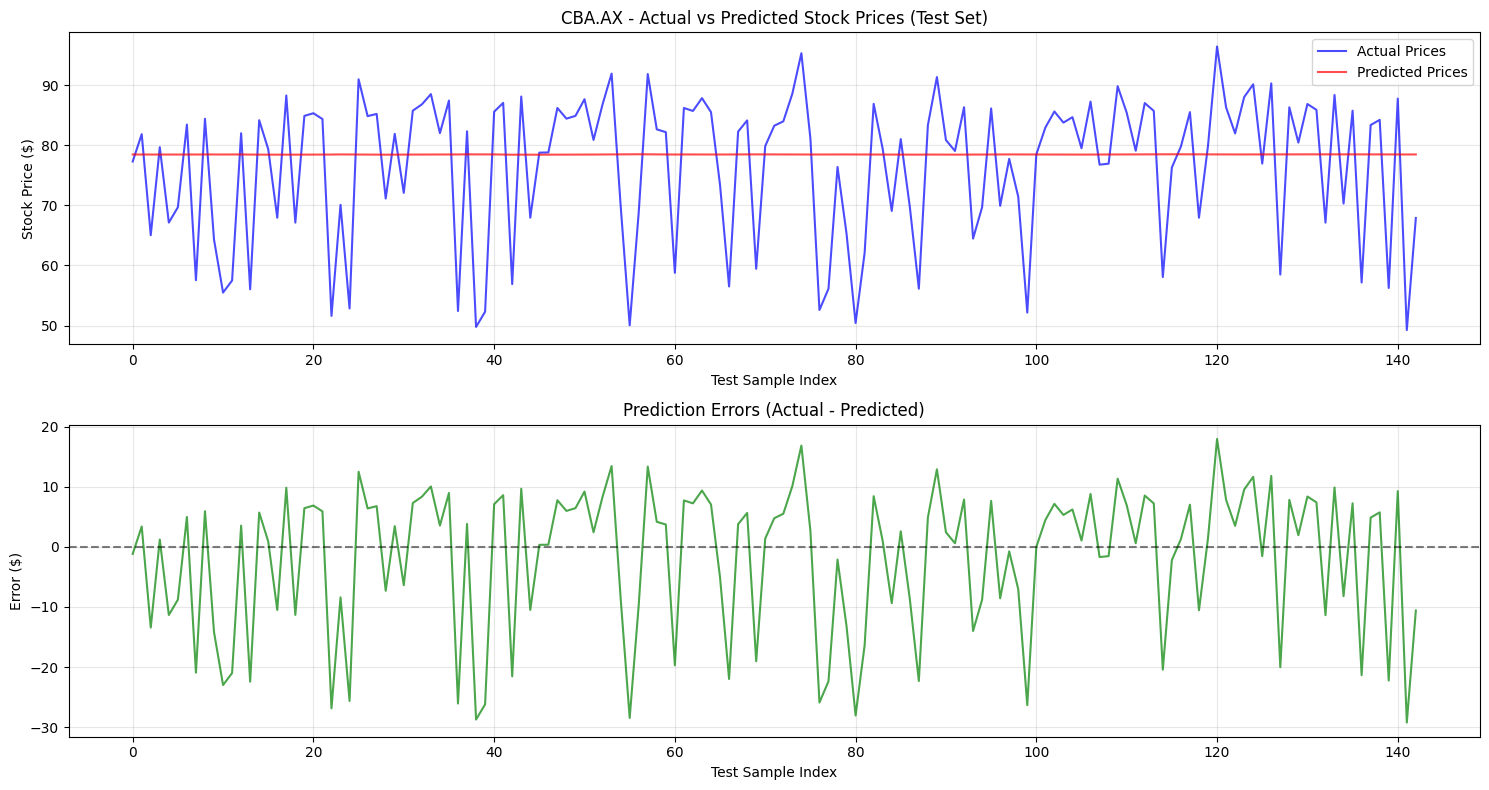


5 Best Predictions (Lowest Error):
           Date  Actual_Price  Predicted_Price  Absolute_Error  \
100  2023-06-08         78.51        78.519997            0.01   
45   2023-03-20         78.80        78.449997            0.34   
46   2023-03-21         78.83        78.459999            0.37   
91   2023-05-26         79.07        78.459999            0.61   
111  2023-06-26         79.11        78.500000            0.61   

     Percentage_Error  
100              0.01  
45               0.44  
46               0.47  
91               0.77  
111              0.78  

5 Worst Predictions (Highest Error):
           Date  Actual_Price  Predicted_Price  Absolute_Error  \
141  2023-08-07         49.25        78.489998           29.24   
38   2023-03-09         49.76        78.500000           28.74   
55   2023-04-03         50.04        78.510002           28.47   
80   2023-05-11         50.42        78.489998           28.07   
22   2023-02-15         51.61        78.480003         

In [8]:
#------------------------------------------------------------------------------
# 5) Make predictions on the test set
#------------------------------------------------------------------------------

print("Making predictions on test set...")

# Make predictions on test data
test_predictions = model.predict(X_test, verbose=0)
print(f"Test predictions shape: {test_predictions.shape}")

# Convert predictions back to original scale
original_test_predictions = inverse_transform_predictions(test_predictions, 'Close', scalers)
original_test_actual = inverse_transform_predictions(y_test.reshape(-1, 1), 'Close', scalers)

# Create a results DataFrame for better visualization
if 'Date' in test_data.columns:
    # Get corresponding dates for test predictions
    # Note: We need to account for the PREDICTION_DAYS offset
    test_dates = test_data['Date'].iloc[PREDICTION_DAYS:PREDICTION_DAYS + len(original_test_predictions)]
    
    results_df = pd.DataFrame({
        'Date': test_dates.values,
        'Actual_Price': original_test_actual,
        'Predicted_Price': original_test_predictions,
        'Absolute_Error': np.abs(original_test_actual - original_test_predictions),
        'Percentage_Error': np.abs((original_test_actual - original_test_predictions) / original_test_actual) * 100
    })
else:
    results_df = pd.DataFrame({
        'Actual_Price': original_test_actual,
        'Predicted_Price': original_test_predictions,
        'Absolute_Error': np.abs(original_test_actual - original_test_predictions),
        'Percentage_Error': np.abs((original_test_actual - original_test_predictions) / original_test_actual) * 100
    })

# Display prediction results
print("\n" + "="*60)
print("TEST SET PREDICTION RESULTS")
print("="*60)

print(f"Number of test predictions: {len(original_test_predictions)}")
print(f"Actual price range: ${original_test_actual.min():.2f} - ${original_test_actual.max():.2f}")
print(f"Predicted price range: ${original_test_predictions.min():.2f} - ${original_test_predictions.max():.2f}")

# Calculate detailed metrics
mae = np.mean(np.abs(original_test_actual - original_test_predictions))
mse = np.mean((original_test_actual - original_test_predictions) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((original_test_actual - original_test_predictions) / original_test_actual)) * 100

print(f"\nPrediction Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {100 - mape:.2f}%")

# Display sample predictions
print(f"\nSample Predictions (First 10):")
print(results_df.head(10).round(2))

print(f"\nSample Predictions (Last 10):")
print(results_df.tail(10).round(2))

# Save predictions to CSV
predictions_filename = f"{DATA_DIR}/{COMPANY}_test_predictions.csv"
results_df.to_csv(predictions_filename, index=False)
print(f"\nPredictions saved to: {predictions_filename}")

# Visualize predictions vs actual
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(original_test_actual, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(original_test_predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.title(f'{COMPANY} - Actual vs Predicted Stock Prices (Test Set)')
plt.xlabel('Test Sample Index')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot prediction errors
plt.subplot(2, 1, 2)
prediction_errors = original_test_actual - original_test_predictions
plt.plot(prediction_errors, color='green', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Prediction Errors (Actual - Predicted)')
plt.xlabel('Test Sample Index')
plt.ylabel('Error ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/{COMPANY}_prediction_results.png", dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Best and worst predictions
best_predictions = results_df.nsmallest(5, 'Percentage_Error')
worst_predictions = results_df.nlargest(5, 'Percentage_Error')

print(f"\n5 Best Predictions (Lowest Error):")
print(best_predictions.round(2))

print(f"\n5 Worst Predictions (Highest Error):")
print(worst_predictions.round(2))

# Statistical summary of errors
print(f"\nError Distribution Summary:")
print(f"Error Statistics:")
print(f"  Mean Error: ${prediction_errors.mean():.2f}")
print(f"  Std Dev of Errors: ${prediction_errors.std():.2f}")
print(f"  Min Error: ${prediction_errors.min():.2f}")
print(f"  Max Error: ${prediction_errors.max():.2f}")
print(f"  25th Percentile: ${np.percentile(prediction_errors, 25):.2f}")
print(f"  75th Percentile: ${np.percentile(prediction_errors, 75):.2f}")

print("="*60)
print("PREDICTION ANALYSIS COMPLETE")
print("="*60)